# Live demo: Processing gravity data with Fatiando a Terra

This notebook is based on the [Harmonica tutorial at Transform 2021](https://github.com/fatiando/transform21).

## Import packages

Start by loading everything we need.

In [1]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr

# For projections (wrapped for Proj)
import pyproj

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

## Data from the Bushveld Igneous Complex (South Africa)

We can use [Pooch](https://www.fatiando.org/pooch) to download data files from anywhere on the web. Let's download some public domain gravity data from the Bushveld Igneous Complex that we have on some GitHub repositories.

In [2]:
url_grav = "https://github.com/fatiando/2021-gsh/raw/main/data/bushveld_gravity.csv"
md5_grav = "md5:45539f7945794911c6b5a2eb43391051"

url_topo = "https://github.com/fatiando/transform21/raw/main/data/bushveld_topography.nc"
md5_topo = "md5:62daf6a114dda89530e88942aa3b8c41"

In [3]:
path_grav = pooch.retrieve(url_grav, known_hash=md5_grav)
path_topo = pooch.retrieve(url_topo, known_hash=md5_topo)

print(path_grav)
print(path_topo)

/home/leo/.cache/pooch/f9087e49a3b8e83d4e2affba9882d9ad-bushveld_gravity.csv
/home/leo/.cache/pooch/da3d295d727d76ff80f092a51df3d2fa-bushveld_topography.nc


Use Pandas to read the gravity data from the CSV file.

In [4]:
data = pd.read_csv(path_grav)
data

,latitude,longitude,elevation,gravity
0,-26.26334,25.01500,1230.16,978681.38
1,-26.38713,25.01932,1297.00,978669.02
2,-26.39667,25.02499,1304.84,978669.28
3,-26.07668,25.04500,1165.24,978681.08
4,-26.35001,25.07668,1262.47,978665.19
...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85
3873,-23.30000,31.52499,280.72,978798.55
3874,-23.19333,31.54832,245.67,978803.55
3875,-23.84833,31.57333,226.77,978808.44


Use xarray to read the topography data from the netCDF file.

In [5]:
topography = xr.load_dataarray(path_topo)
topography

<xarray.DataArray 'bedrock' (latitude: 240, longitude: 419)>
array([[1257., 1260., 1266., ...,  195.,  201.,  425.],
       [1245., 1254., 1261., ...,  206.,  215.,  375.],
       [1256., 1258., 1268., ...,  200.,  232.,  300.],
       ...,
       [1029., 1031., 1033., ...,  248.,  242.,  238.],
       [1029., 1031., 1033., ...,  247.,  242.,  237.],
       [1028., 1030., 1032., ...,  247.,  241.,  238.]])
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Attributes:
    long_name:       Bedrock relief
    actual_range:    [-10898.   8271.]
    units:           meters
    vertical_datum:  sea level
    datum:           WGS84

Use pygmt to plot the data.

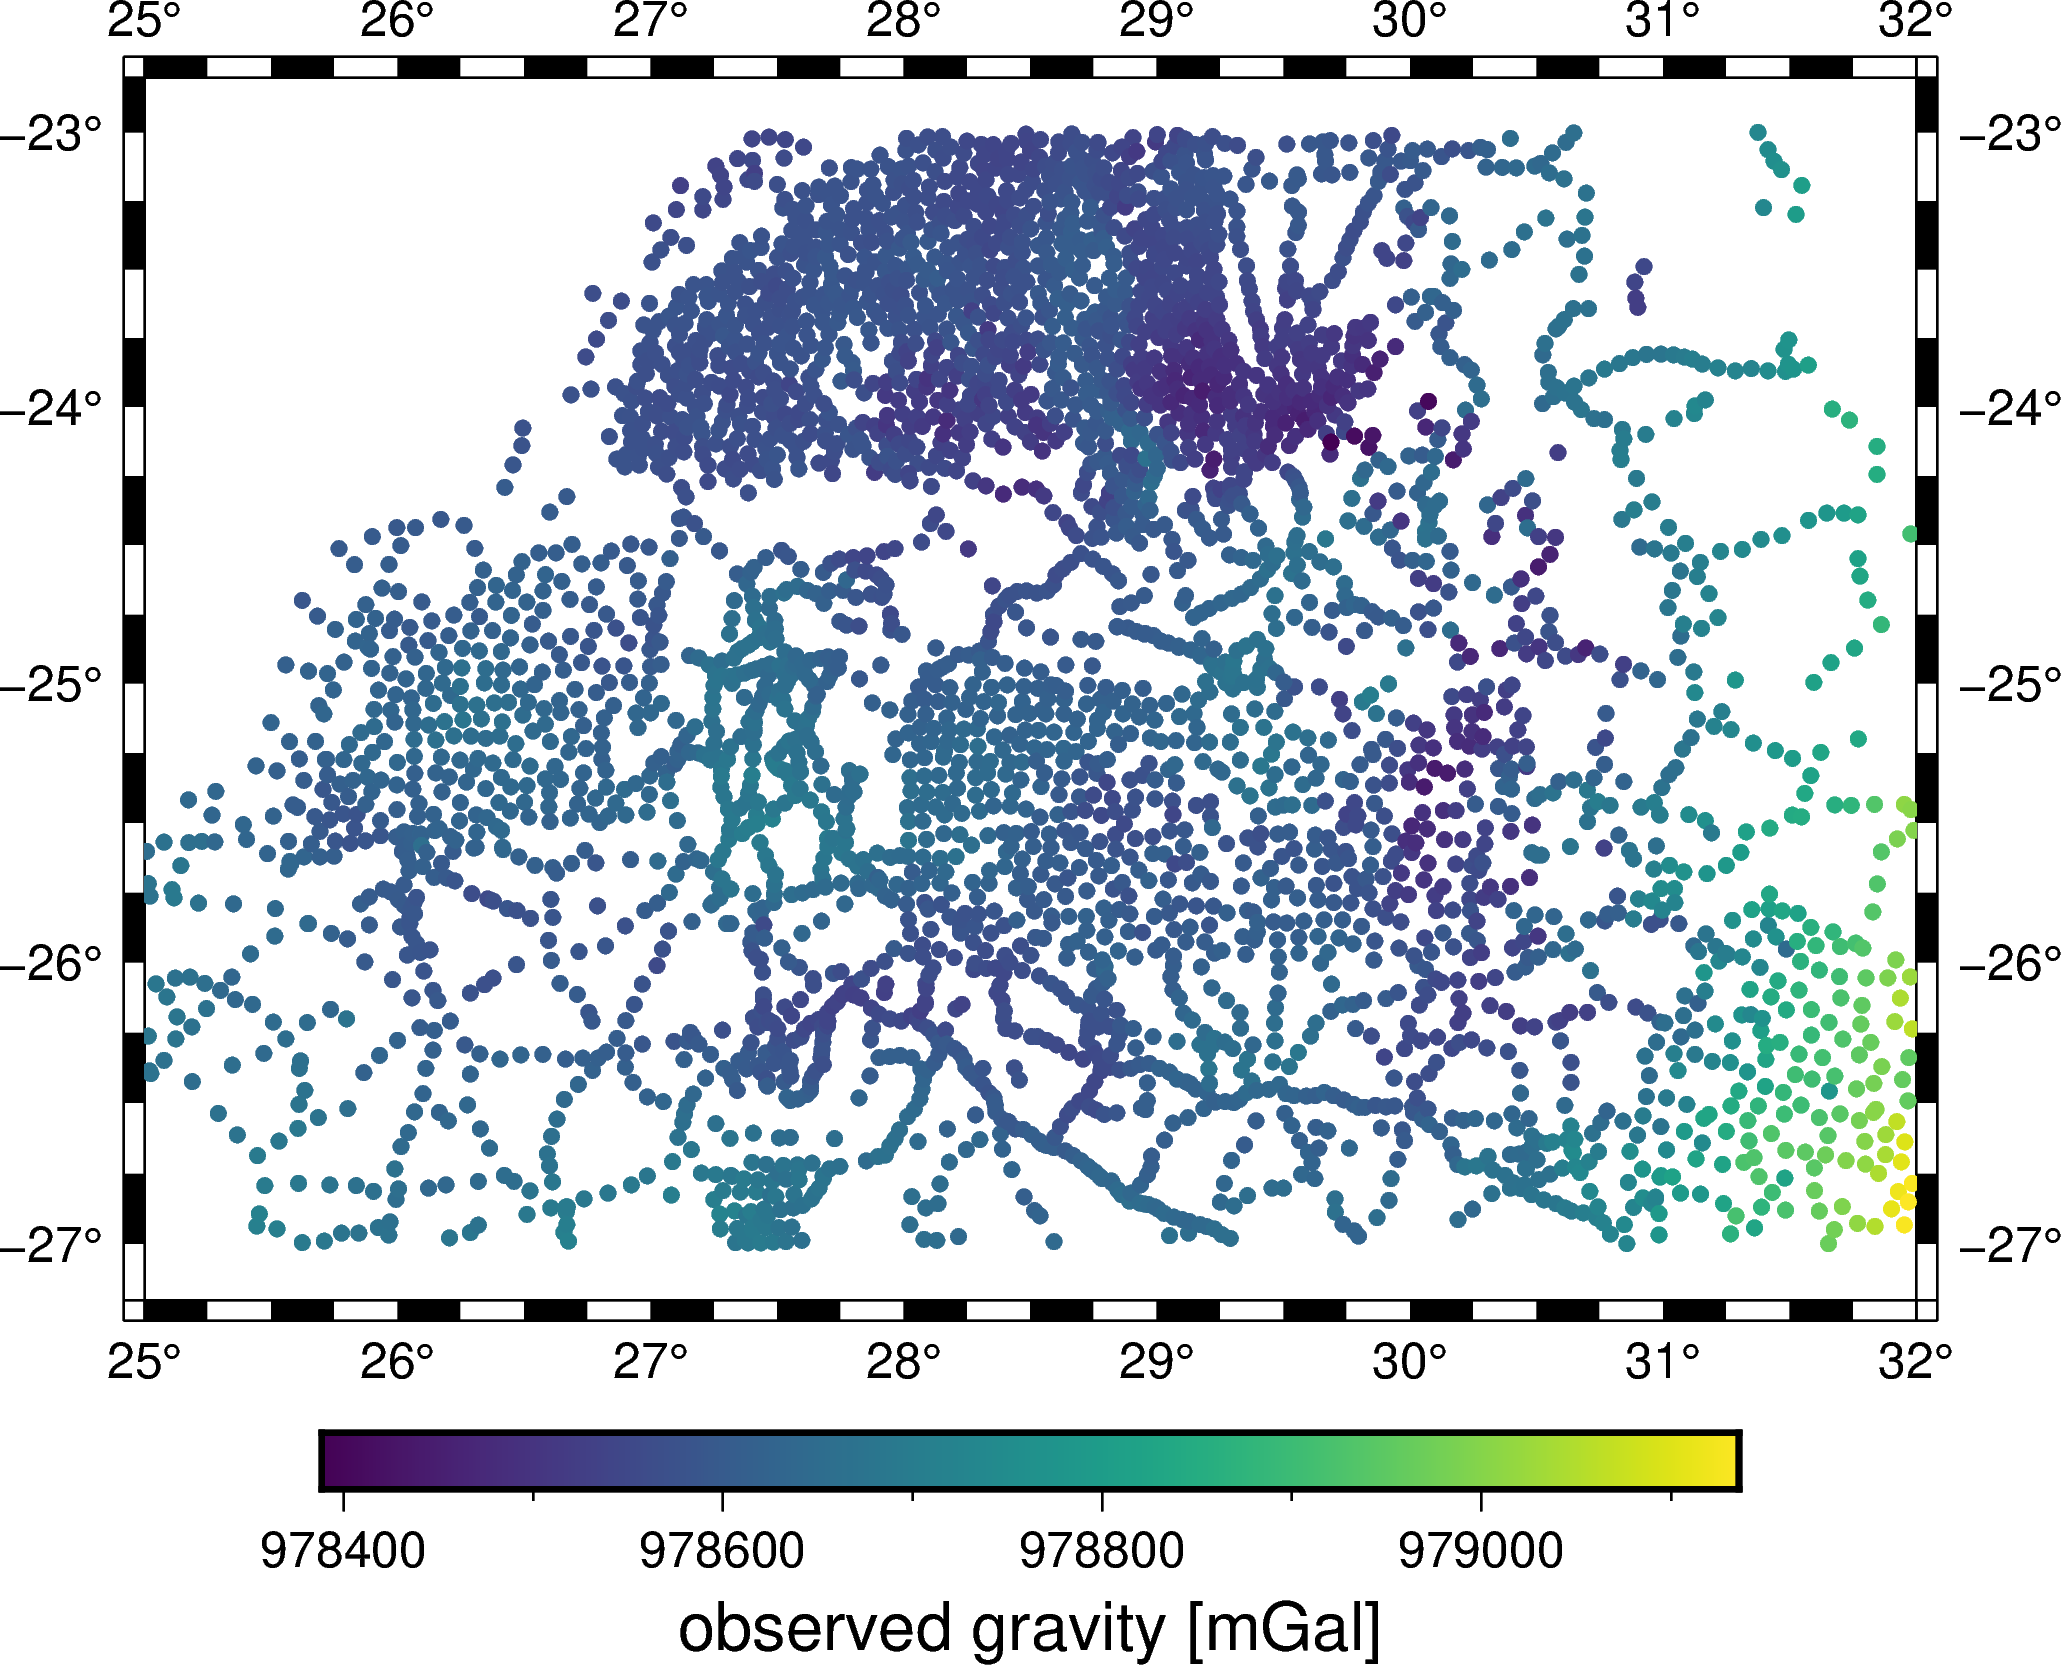

In [6]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="viridis", series=[data.gravity.min(), data.gravity.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame=True,
)
fig.colorbar(frame='af+l"observed gravity [mGal]"')
fig.show()

grdinfo [WARNING]: The x-coordinates and range attribute are in conflict but range is exactly 360; we rely on this range
grdinfo [WARNING]: The y-coordinates and range attribute are in conflict but range is exactly 180; we rely on this range


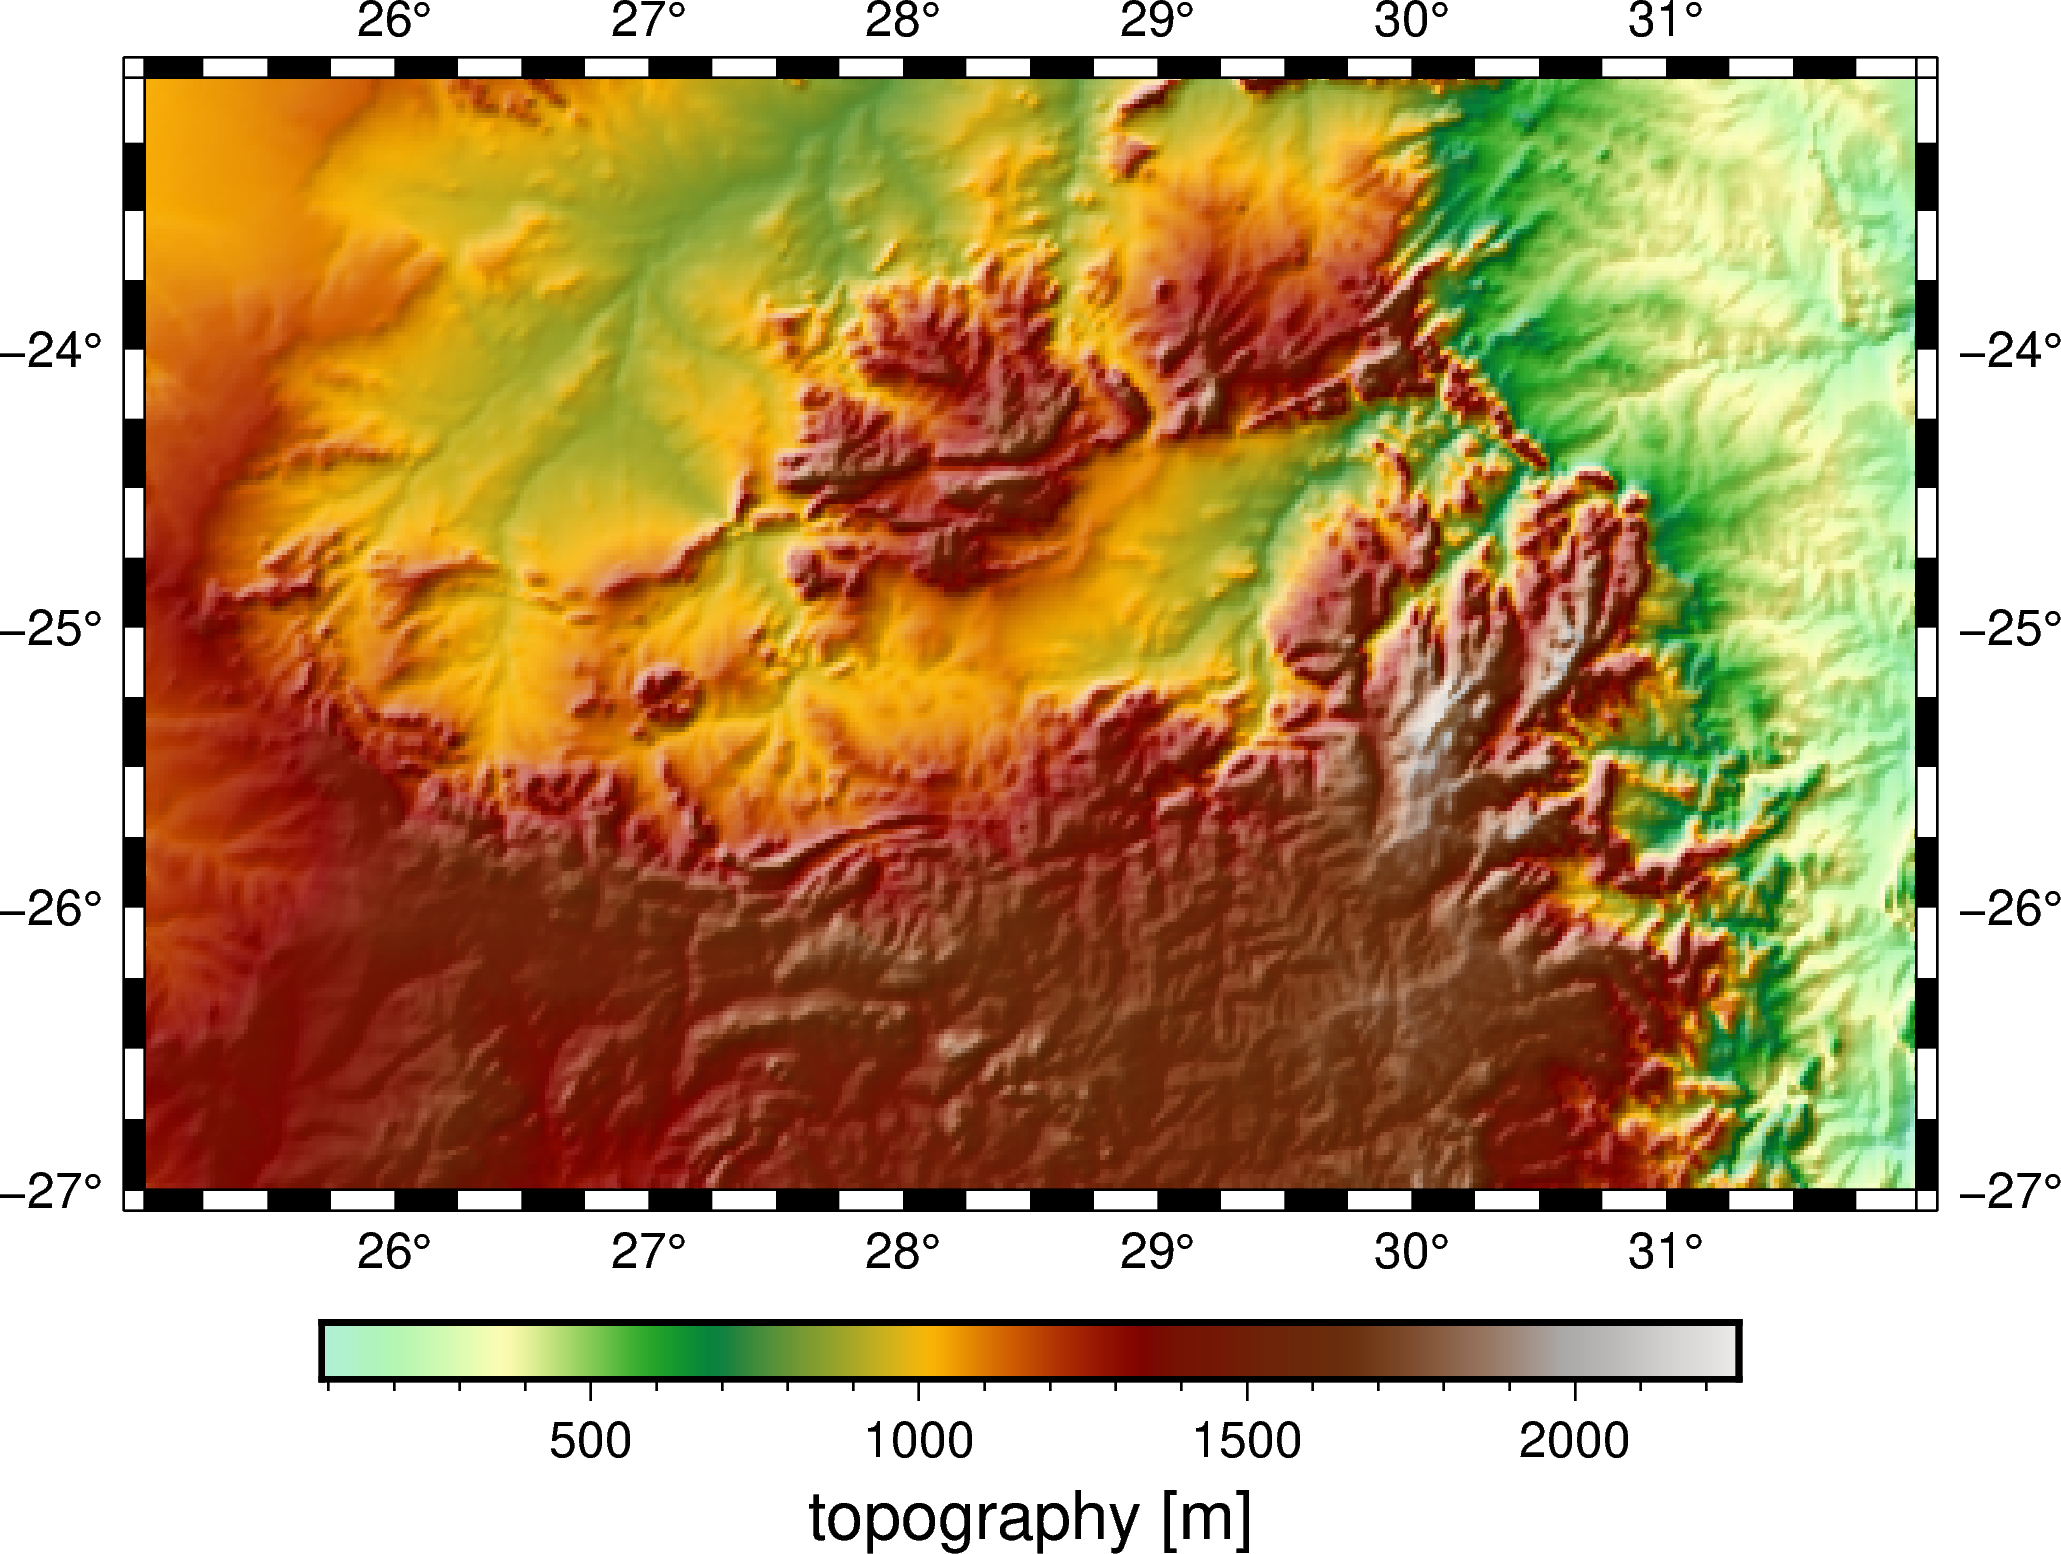

In [7]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="earth", series=[topography.values.min(), topography.values.max()])
fig.grdimage(topography, shading=True, projection="M15c", frame=True)
fig.colorbar(frame='af+l"topography [m]"')
fig.show()

## Gravity disturbance

We can use [Boule](https://www.fatiando.org/boule) for computing the normal gravity of the WGS84 reference ellipsoid on any point.

In [8]:
ellipsoid = bl.WGS84
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.elevation)
normal_gravity

0       978664.725301
1       978652.988542
2       978651.255750
3       978671.414340
4       978660.974215
            ...      
3872    978785.393559
3873    978754.230966
3874    978758.068460
3875    978807.159627
3876    978733.156141
Length: 3877, dtype: float64

And compute the gravity disturbance as the difference between the observed gravity and the normal gravity:

In [9]:
data["disturbance"] = data.gravity - normal_gravity
data

,latitude,longitude,elevation,gravity,disturbance
0,-26.26334,25.01500,1230.16,978681.38,16.654699
1,-26.38713,25.01932,1297.00,978669.02,16.031458
2,-26.39667,25.02499,1304.84,978669.28,18.024250
3,-26.07668,25.04500,1165.24,978681.08,9.665660
4,-26.35001,25.07668,1262.47,978665.19,4.215785
...,...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85,-8.543559
3873,-23.30000,31.52499,280.72,978798.55,44.319034
3874,-23.19333,31.54832,245.67,978803.55,45.481540
3875,-23.84833,31.57333,226.77,978808.44,1.280373


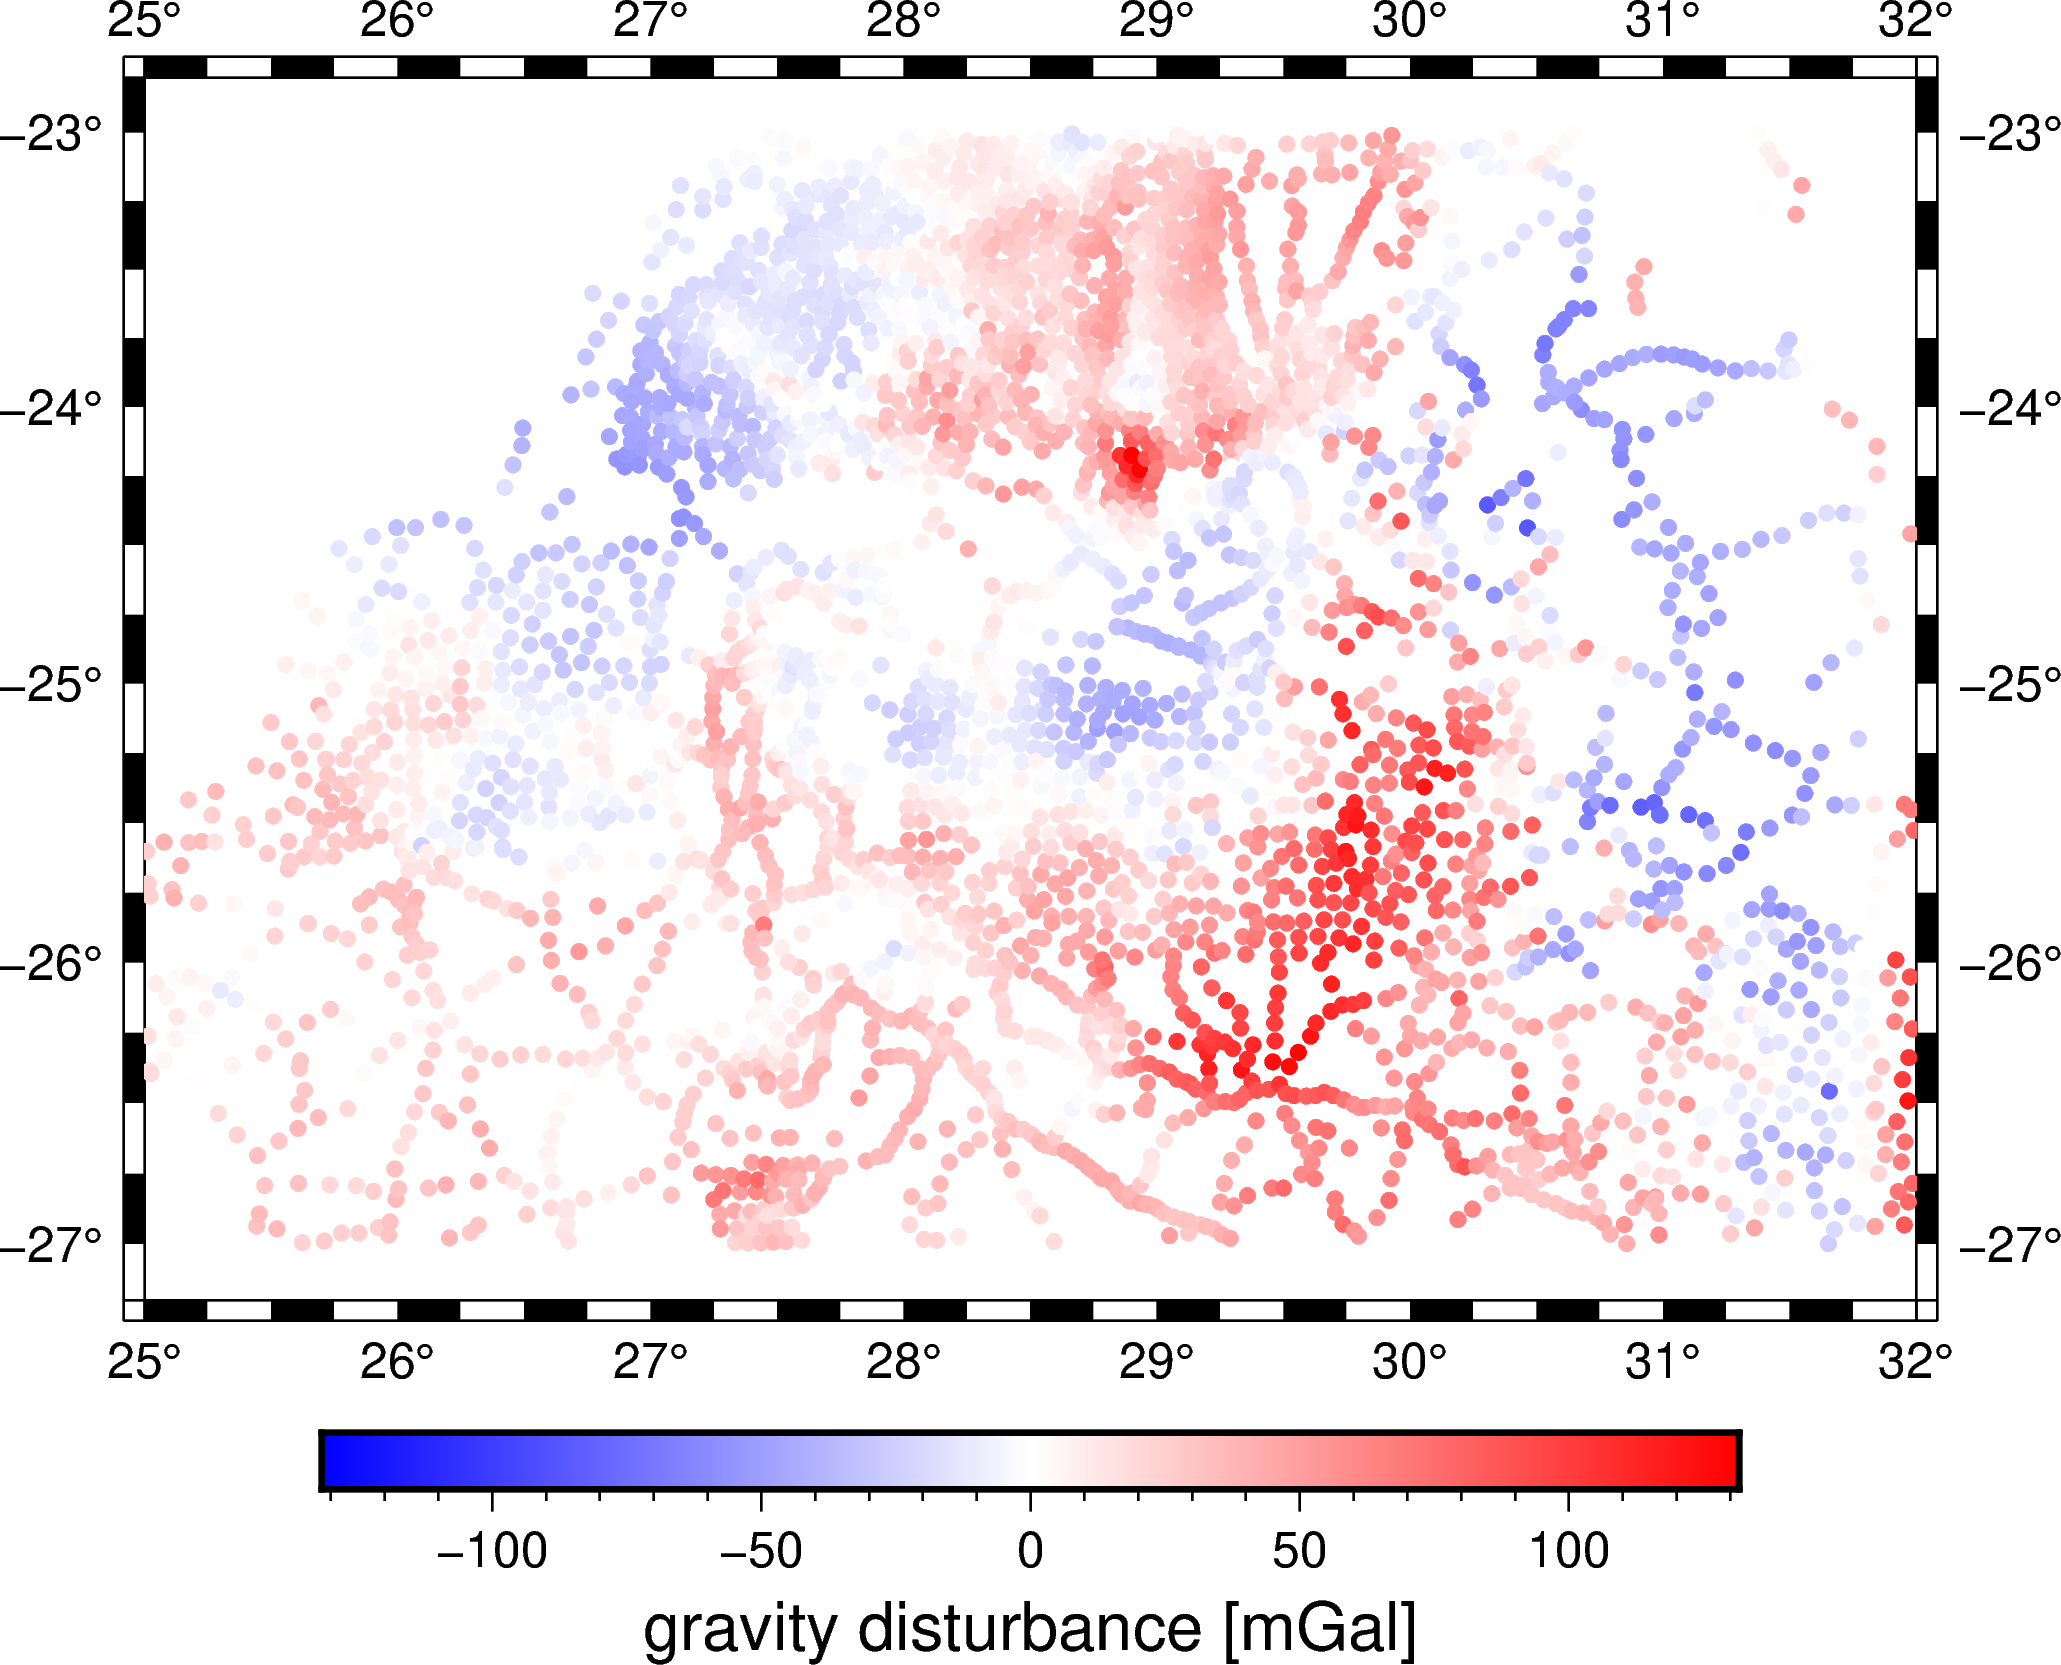

In [10]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.disturbance)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.disturbance,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame=True,
)

fig.colorbar(frame='af+l"gravity disturbance [mGal]"')
fig.show()

## Project the data

From here on, we will work in Cartesian coordinates. We need to project our data so that we can do topographic correction and remove trends.

Define the Mercator projeciton using `pyproj`:

In [11]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

And use it to project the gravity data.

In [12]:
easting, northing = projection(data.longitude.values, data.latitude.values)
data["easting"] = easting
data["northing"] = northing
data

,latitude,longitude,elevation,gravity,disturbance,easting,northing
0,-26.26334,25.01500,1230.16,978681.38,16.654699,2.526066e+06,-2.733052e+06
1,-26.38713,25.01932,1297.00,978669.02,16.031458,2.526503e+06,-2.746924e+06
2,-26.39667,25.02499,1304.84,978669.28,18.024250,2.527075e+06,-2.747994e+06
3,-26.07668,25.04500,1165.24,978681.08,9.665660,2.529096e+06,-2.712163e+06
4,-26.35001,25.07668,1262.47,978665.19,4.215785,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85,-8.543559,3.182450e+06,-2.466945e+06
3873,-23.30000,31.52499,280.72,978798.55,44.319034,3.183459e+06,-2.405224e+06
3874,-23.19333,31.54832,245.67,978803.55,45.481540,3.185814e+06,-2.393567e+06
3875,-23.84833,31.57333,226.77,978808.44,1.280373,3.188340e+06,-2.465298e+06


The topography grid is a bit trickier but we can use Verde to do the projection.

In [13]:
topo_plain = vd.project_grid(topography, projection=projection)
topo_plain

<xarray.DataArray 'bedrock' (northing: 240, easting: 419)>
array([[1257.        , 1260.        , 1266.        , ...,  195.        ,
         201.        ,  425.        ],
       [1245.19963571, 1254.09981785, 1261.08318154, ...,  205.8170006 ,
         214.76709167,  375.83181545],
       [1255.63559308, 1257.86748839, 1267.76810468, ...,  200.19876741,
         231.43682566,  302.48459266],
       ...,
       [1029.03190101, 1031.        , 1033.03190101, ...,  248.06380202,
         242.03190101,  238.03190101],
       [1028.67199134, 1030.67199134, 1032.67199134, ...,  247.34398268,
         241.67199134,  237.67199134],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

## Topographic correction

We can use [Harmonica](https://www.fatiando.org/harmonica) for forward modelling the gravitational effect of the terrain through rectangular prisms.

First, define a layer of prisms from the topography grid.

In [14]:
topo_prisms = hm.prism_layer(
    coordinates=(topo_plain.easting, topo_plain.northing),
    surface=topo_plain.values,
    reference=0,
    properties={"density": 2670 * np.ones_like(topo_plain)}
)
topo_prisms

<xarray.Dataset>
Dimensions:   (easting: 419, northing: 240)
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
    top       (northing, easting) float64 1.257e+03 1.26e+03 ... nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

Second, forward model the gravitational effect of the terrain at the data points.

In [15]:
%%time

coordinates = (data.easting, data.northing, data.elevation)
terrain_effect = topo_prisms.prism_layer.gravity(coordinates, field="g_z")
terrain_effect

CPU times: user 5min 28s, sys: 1.2 s, total: 5min 29s
Wall time: 45.5 s


array([106.19254474, 120.69908073, 128.83454894, ...,  24.13315229,
        23.5862158 ,   0.44730556])

Calculate the Bouguer disturbance (topography-free).

In [16]:
data["bouguer"] = data.disturbance - terrain_effect
data

,latitude,longitude,elevation,gravity,disturbance,easting,northing,bouguer
0,-26.26334,25.01500,1230.16,978681.38,16.654699,2.526066e+06,-2.733052e+06,-89.537846
1,-26.38713,25.01932,1297.00,978669.02,16.031458,2.526503e+06,-2.746924e+06,-104.667623
2,-26.39667,25.02499,1304.84,978669.28,18.024250,2.527075e+06,-2.747994e+06,-110.810299
3,-26.07668,25.04500,1165.24,978681.08,9.665660,2.529096e+06,-2.712163e+06,-112.746215
4,-26.35001,25.07668,1262.47,978665.19,4.215785,2.532295e+06,-2.742763e+06,-132.438822
...,...,...,...,...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85,-8.543559,3.182450e+06,-2.466945e+06,-41.414821
3873,-23.30000,31.52499,280.72,978798.55,44.319034,3.183459e+06,-2.405224e+06,14.552989
3874,-23.19333,31.54832,245.67,978803.55,45.481540,3.185814e+06,-2.393567e+06,21.348388
3875,-23.84833,31.57333,226.77,978808.44,1.280373,3.188340e+06,-2.465298e+06,-22.305842


Plot it with pygmt.

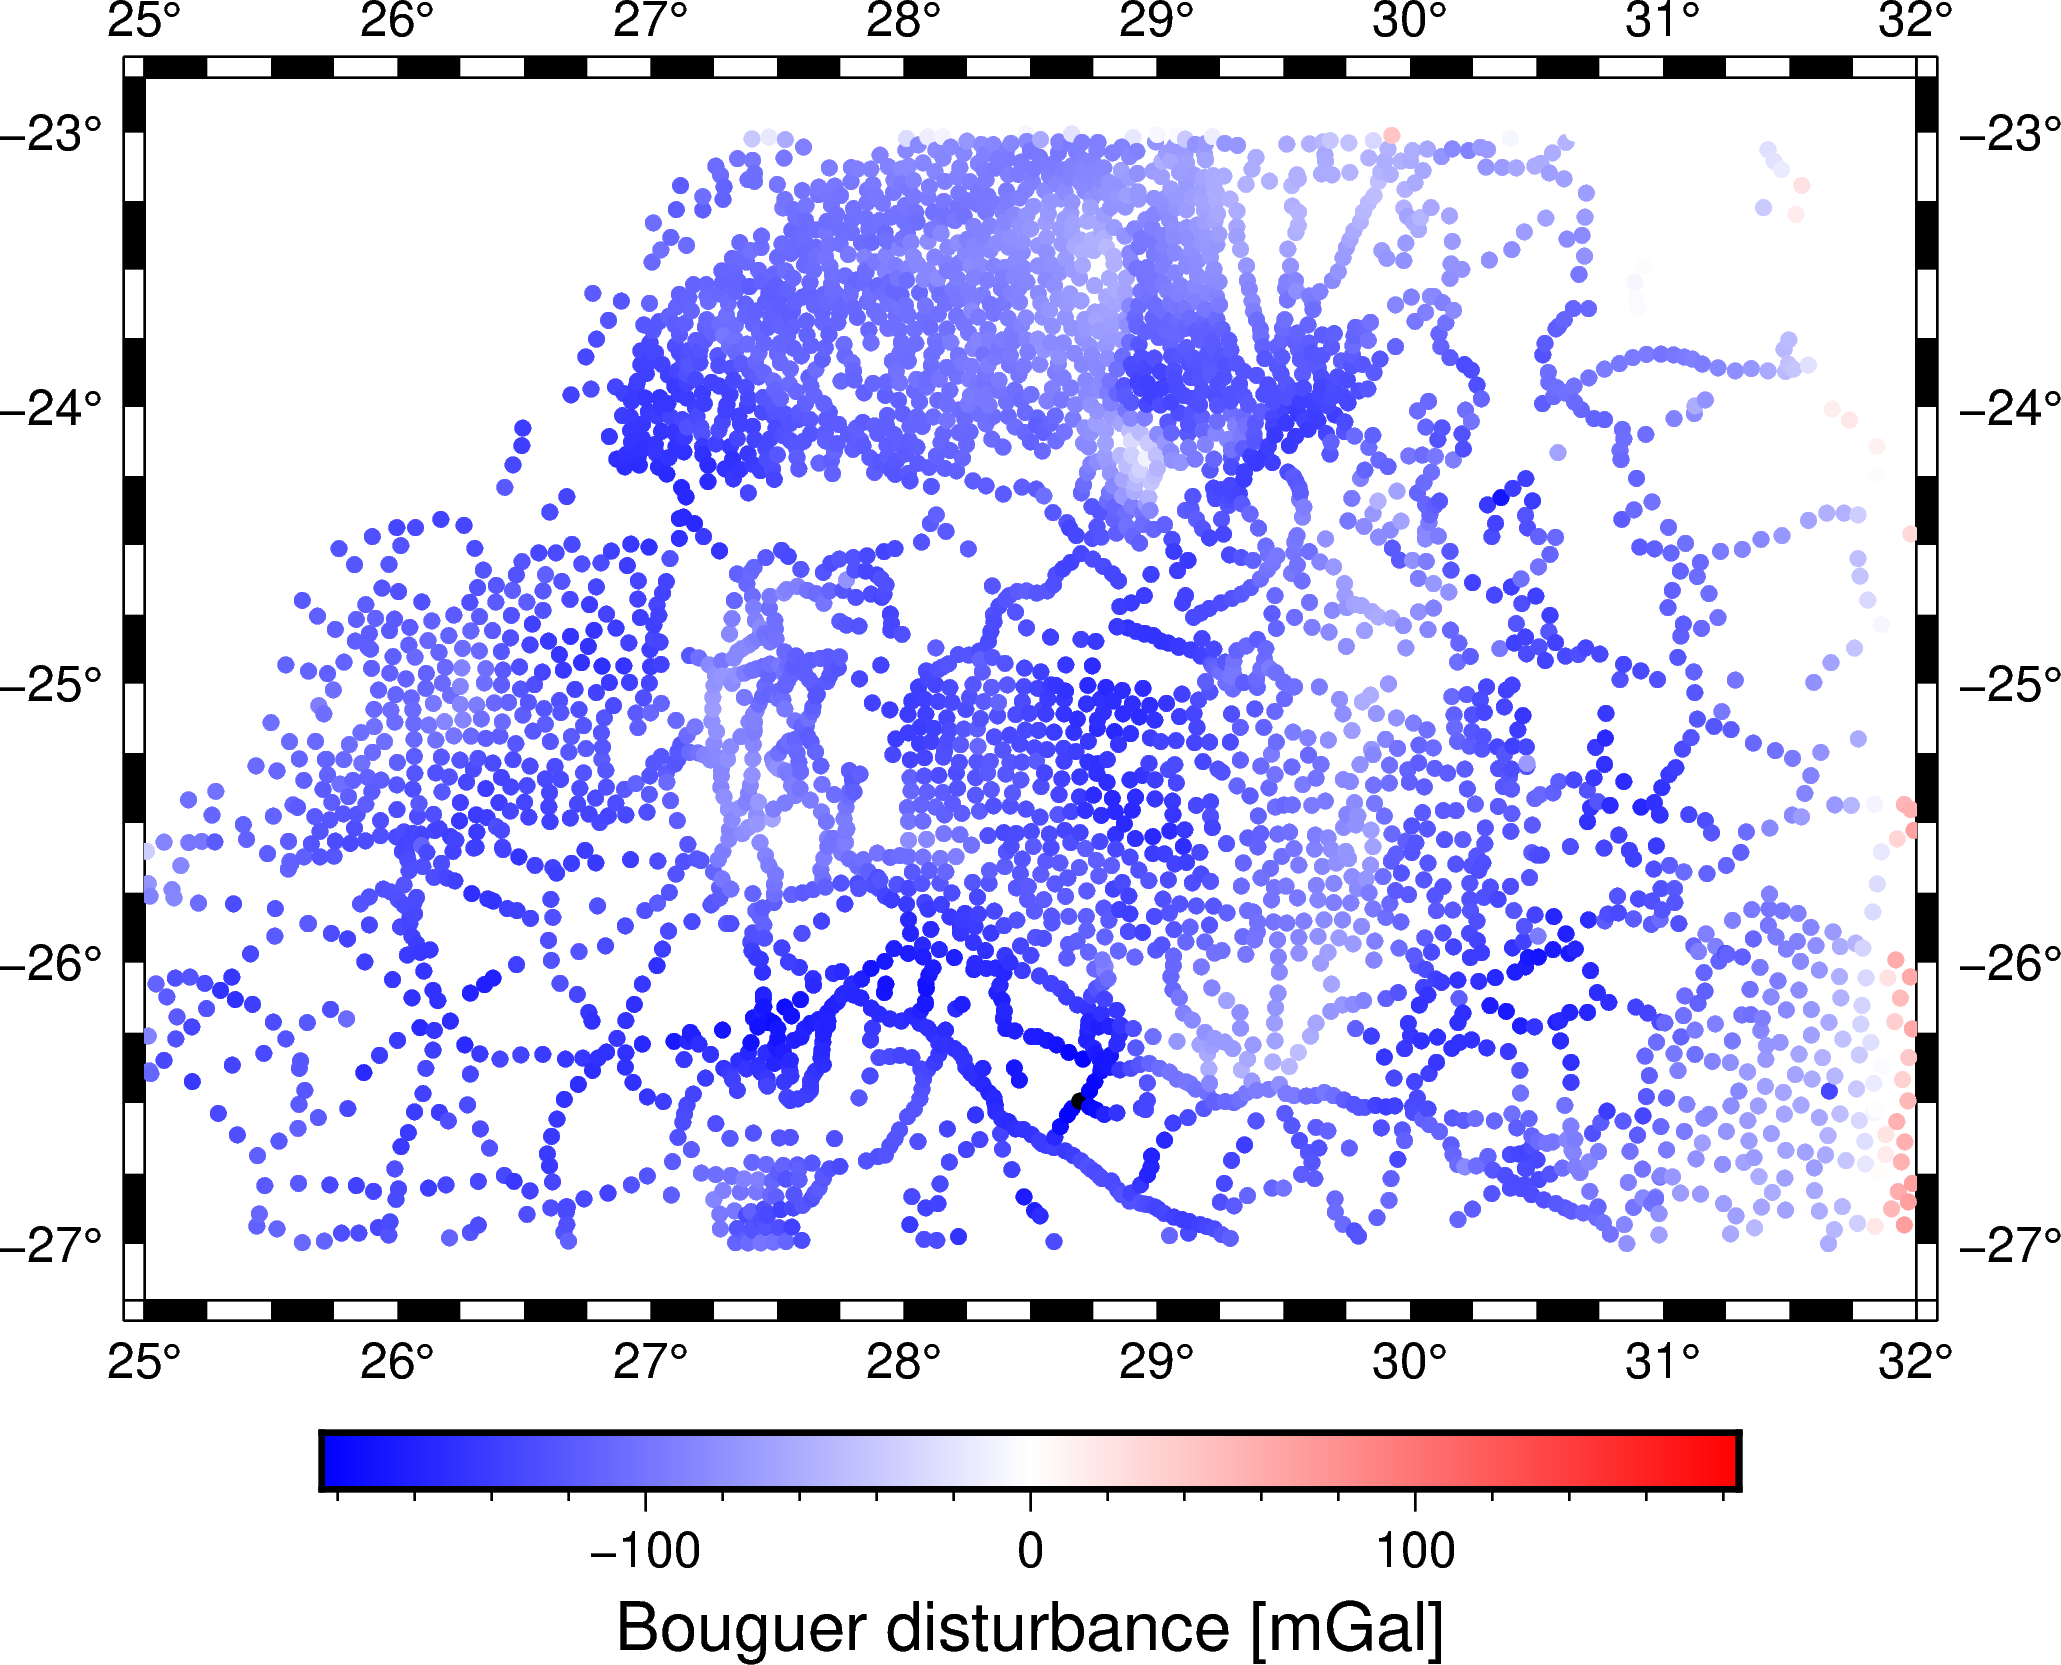

In [17]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.bouguer)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.bouguer,
    cmap=True,
    style="c4p",
    projection="M15c", 
    frame=True,
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.show()

## Regional-residual separation

We can use [Verde](https://www.fatiando.org/verde) to remove a second degree trend from the Bouguer disturbance.

In [18]:
trend = vd.Trend(degree=2).fit(coordinates, data.bouguer)

data["residuals"] = data.bouguer - trend.predict(coordinates)
data

,latitude,longitude,elevation,gravity,disturbance,easting,northing,bouguer,residuals
0,-26.26334,25.01500,1230.16,978681.38,16.654699,2.526066e+06,-2.733052e+06,-89.537846,20.684260
1,-26.38713,25.01932,1297.00,978669.02,16.031458,2.526503e+06,-2.746924e+06,-104.667623,5.388493
2,-26.39667,25.02499,1304.84,978669.28,18.024250,2.527075e+06,-2.747994e+06,-110.810299,-0.669367
3,-26.07668,25.04500,1165.24,978681.08,9.665660,2.529096e+06,-2.712163e+06,-112.746215,-1.911494
4,-26.35001,25.07668,1262.47,978665.19,4.215785,2.532295e+06,-2.742763e+06,-132.438822,-21.158725
...,...,...,...,...,...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85,-8.543559,3.182450e+06,-2.466945e+06,-41.414821,16.041181
3873,-23.30000,31.52499,280.72,978798.55,44.319034,3.183459e+06,-2.405224e+06,14.552989,57.135913
3874,-23.19333,31.54832,245.67,978803.55,45.481540,3.185814e+06,-2.393567e+06,21.348388,60.092123
3875,-23.84833,31.57333,226.77,978808.44,1.280373,3.188340e+06,-2.465298e+06,-22.305842,33.148334


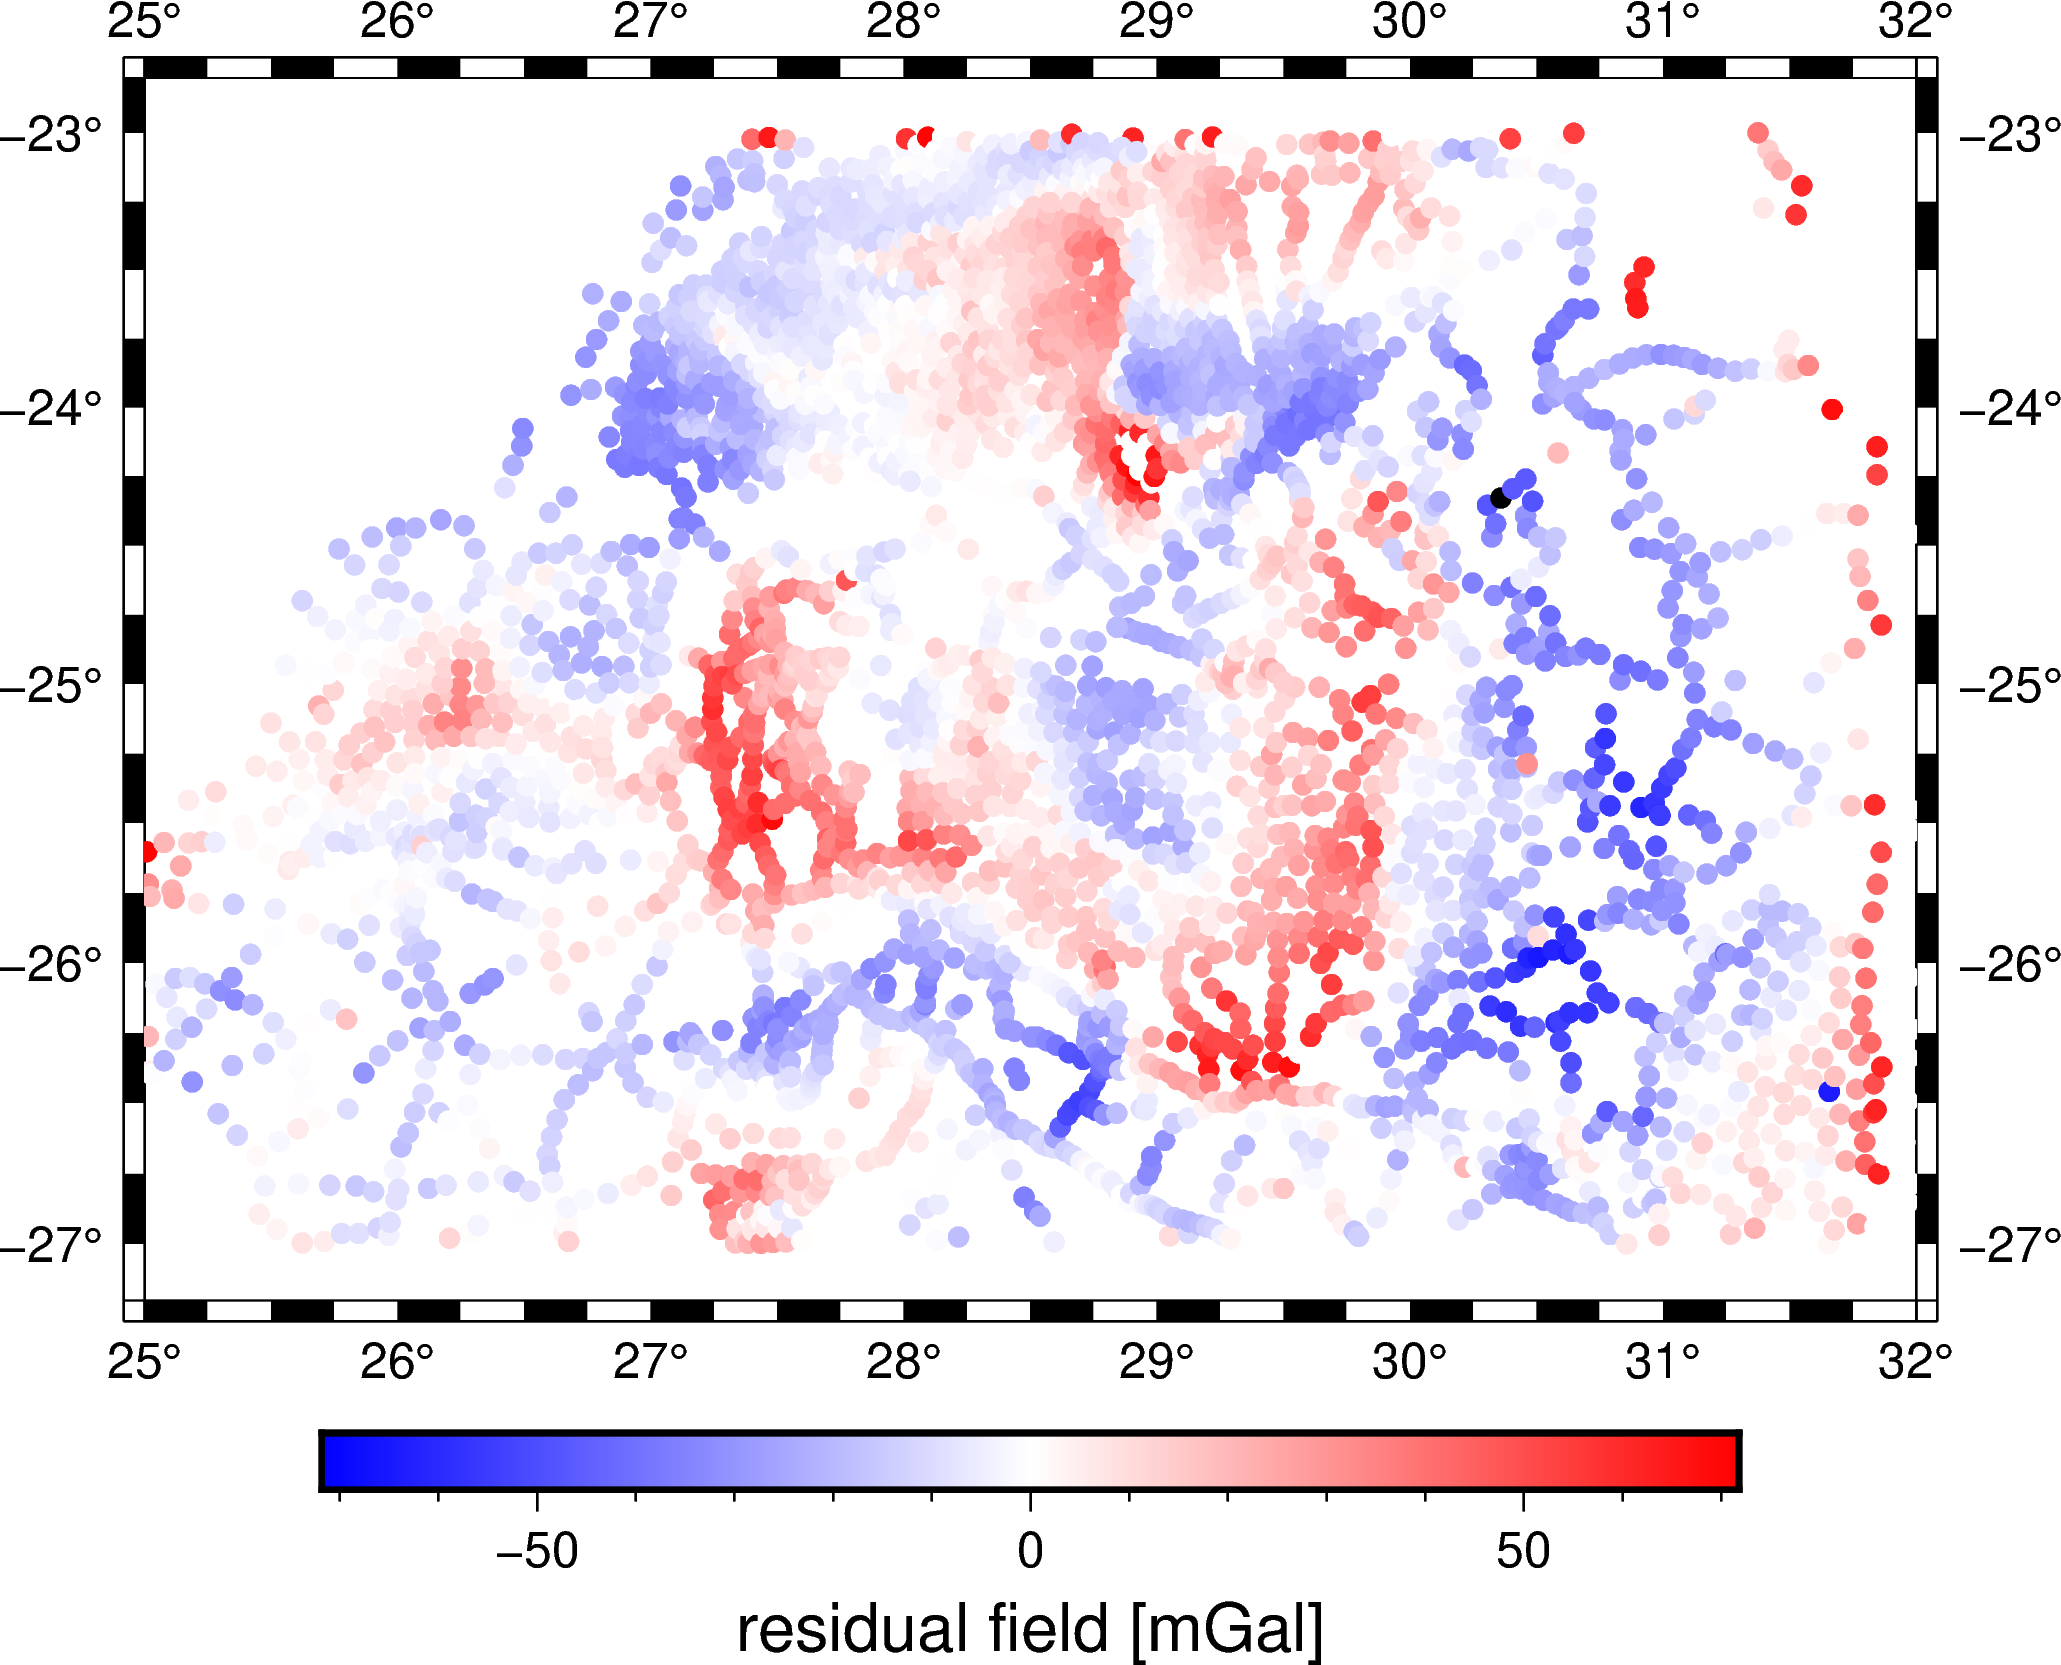

In [19]:
fig = pygmt.Figure()
maxabs = np.quantile(np.abs(data.residuals), 0.99)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.residuals,
    cmap=True,
    style="c5p",
    projection="M15c", 
    frame=True,
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.show()

## Grid the residuals with Equivalent Sources

Use the equivalent sources implementation in Harmonica to grid the residuals and upward-continue them to the same height (all in one step).

In [20]:
%%time

eql = hm.EQLHarmonic(damping=100, relative_depth=10e3)
eql.fit(coordinates, data.residuals)

CPU times: user 8.94 s, sys: 2.9 s, total: 11.8 s
Wall time: 2.43 s


EQLHarmonic(damping=100, relative_depth=10000.0)

Use the source model to forward model the grid at a uniform height. We can use the projection to generate a grid in **geographic coordinates** instead of Cartesian.

In [21]:
%%time

region = vd.get_region((data.longitude, data.latitude))

grid = eql.grid(
    upward=2200,
    region=region,
    spacing=0.02,
    data_names=["residuals"],
    dims=("latitude", "longitude"),
    projection=projection,
)

grid

CPU times: user 3.02 s, sys: 26.1 ms, total: 3.04 s
Wall time: 962 ms


<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 350)
Coordinates:
  * longitude  (longitude) float64 25.01 25.03 25.05 25.07 ... 31.95 31.97 31.99
  * latitude   (latitude) float64 -27.0 -26.98 -26.96 ... -23.04 -23.02 -23.0
    upward     (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03 2.2e+03
Data variables:
    residuals  (latitude, longitude) float64 -0.8214 -0.838 ... 17.12 16.79
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100, relative_depth=10000.0)

Plot the gridded residuals.

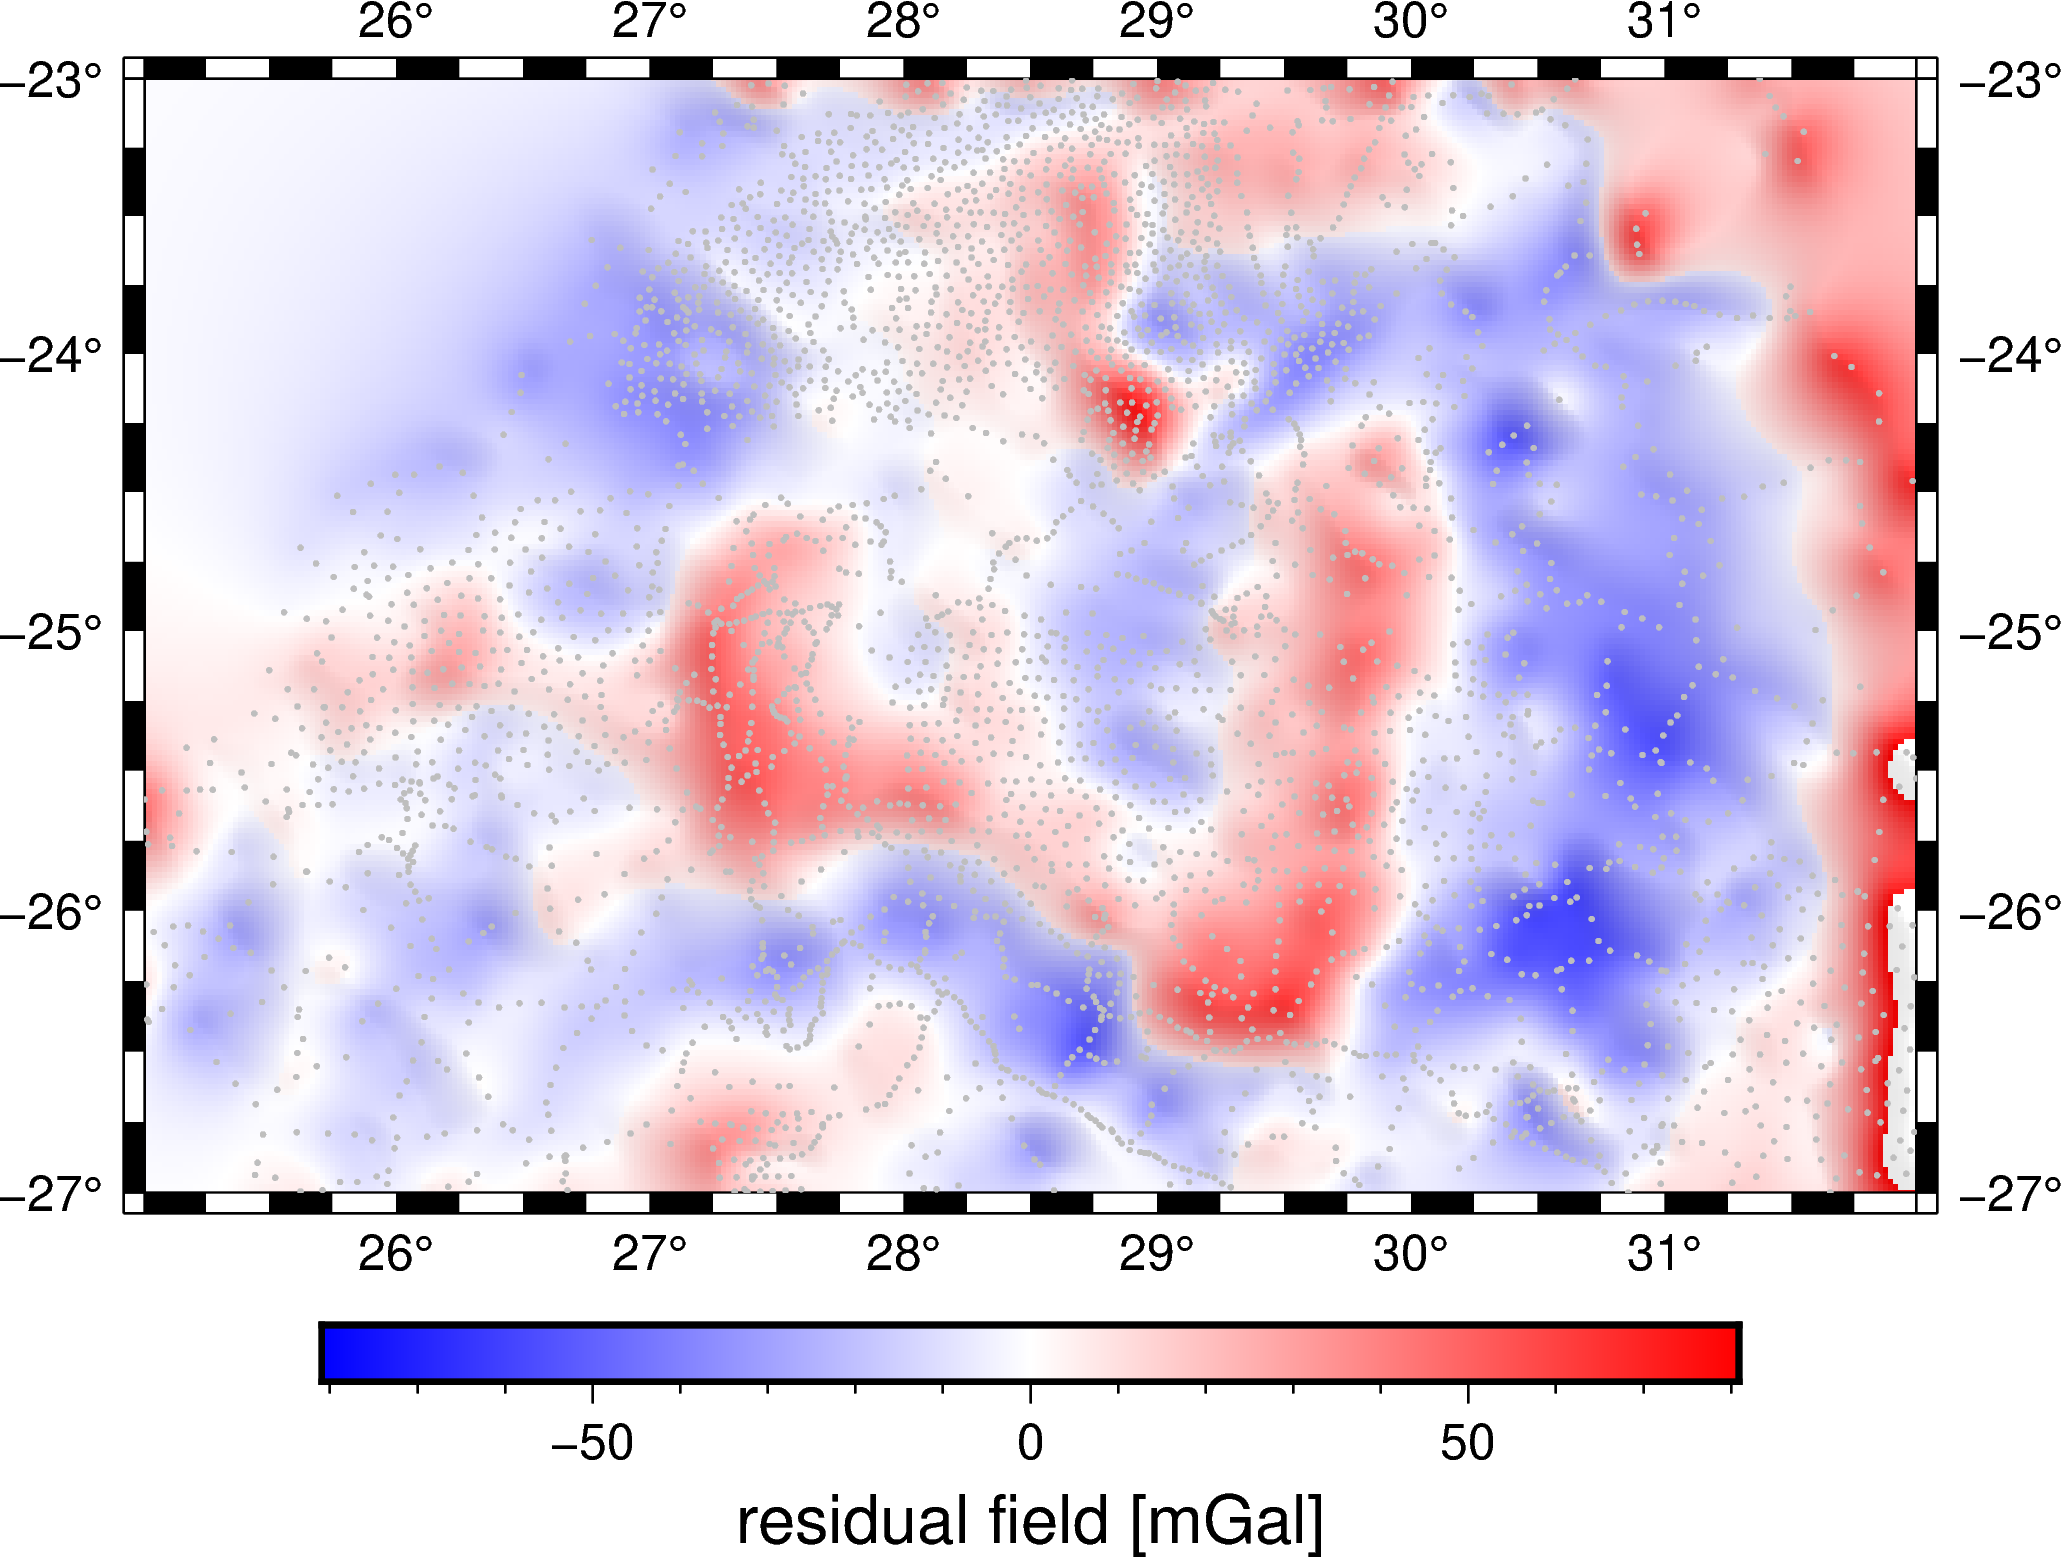

In [22]:
fig = pygmt.Figure()
scale = np.quantile(np.abs(grid.residuals), 0.995)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(
    grid.residuals,
    shading="+a45+nt0.15",
    cmap=True,
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.05c",
    color="gray",
)
fig.show()